# Part A : Probabilistic Gaussian Generative Classifier

## 1. Estimating the class priors π_k

In [121]:
def calc_pi_k (y_train):
    return np.bincount(y_train) / len(y_train)

## 2. Estimating the class means μ_k

In [122]:
def calc_class_means(X_train_scaled, y_train):
    mu_k = np.zeros((10, 64))

    for k in range(10):
        X_class_k = X_train_scaled[y_train == k]
        mu_k[k] = X_class_k.mean(axis=0)
    return mu_k

## 4. Regularising the covariance

In [123]:
def Reg_Covariance (cov_mat, hyper_lambda):
    Reg_mat = hyper_lambda * np.identity(64)
    return cov_mat + Reg_mat

## 3. Estimate the shared covariance matrix Σ

In [124]:
def calc_covariance (X_train_scaled , y_train , mu_k, hyper_lambda):
    cov_mat = np.zeros((64, 64))
    for i in range(X_train_scaled.shape[0]):
        v = X_train_scaled[i] - mu_k[y_train[i]]
        cov_mat += np.outer(v, v)
    cov_mat /= X_train_scaled.shape[0]
    return Reg_Covariance(cov_mat, hyper_lambda)


## Main training function

In [125]:
def train_generative_model(X_train_scaled,y_train,hyper_lambda):
    pi_k = calc_pi_k(y_train)
    mu_k = calc_class_means(X_train_scaled,y_train)
    cov_mat_reg = calc_covariance(X_train_scaled, y_train, mu_k , hyper_lambda)
    return pi_k, mu_k, cov_mat_reg

def predict_new_point(x , pi_k , mu_k, cov_mat_reg):
    #Formula : log p(y = k | x) ∝ log π_k + log N(x ; μ_k, Σ_λ) : logN(x ; μk​, Σλ​)= −0.5 ​(x−μk​)^T Σλ^−1 ​(x−μk​) − 0.5 ​log∣Σλ​∣ − d/2 log(2π)
    cov_mat_reg_inv = np.linalg.inv(cov_mat_reg)
    classes, features = mu_k.shape

    log_det_cov = np.linalg.slogdet(cov_mat_reg)[1]
    scores = np.zeros(classes)
    for i in range(classes):
        diff = x - mu_k[i]
        scores[i] = np.log(pi_k[i]) - 0.5 * diff.T @ cov_mat_reg_inv @ diff - 0.5 * log_det_cov - 0.5 * features * np.log(2 * np.pi)
    return np.argmax(scores)

## Find best lambda

In [126]:
def calc_val_accuracy(X_val_scaled, y_val ,pi_k, mu_k, cov_mat_reg):
    y_predicted = []
    n = X_val_scaled.shape[0]
    for i in range(n):
        y_val_predicted = predict_new_point(X_val_scaled[i] , pi_k, mu_k, cov_mat_reg)
        y_predicted.append(y_val_predicted)
    y_predicted = np.array(y_predicted)
    return np.mean( y_predicted == y_val )
def calc_best_lambda(X_train_scaled, y_train, X_val_scaled, y_val, lambdas):
    val_accuracies = [0] * len(lambdas)
    for i in range(len(lambdas)):
        current_pi_k, current_mu_k,current_cov_mats_reg = train_generative_model(X_train_scaled, y_train, lambdas[i])
        val_accuracies[i] = calc_val_accuracy(X_val_scaled, y_val, current_pi_k, current_mu_k,current_cov_mats_reg)
        print(f"Validation accuracy for lambda =   {lambdas[i]}   is   {val_accuracies[i]}" )
    print(f"Best lambda is : {lambdas[val_accuracies.index(max(val_accuracies))]}")
    return lambdas[val_accuracies.index(max(val_accuracies))]


## Applying best lambda on model

In [127]:
def train_best_lambda(X_train_scaled , X_val_scaled , y_train, y_val , best_lambda):
    X = np.concatenate((X_train_scaled , X_val_scaled) , axis = 0)
    y = np.concatenate((y_train , y_val) , axis = 0)
    pi_k, mu_k, cov_mat_reg = train_generative_model(X , y , best_lambda)
    return pi_k, mu_k, cov_mat_reg

## Testing best-lambda Model

In [128]:
import seaborn as sb

def compute_metrics( y_predicted , y_test):
    test_accuracy = np.mean( y_predicted == y_test)

    cm = np.zeros((10 , 10),dtype=int)
    for label , prediction in zip(y_test , y_predicted):
        cm[label , prediction] += 1

    precisions = []
    recalls = []
    f1s = []

    for k in range(10):
        TP = cm[k, k]
        FP = cm[:, k].sum() - TP
        FN = cm[k, :].sum() - TP

        prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1  = (2 * prec * rec / (prec + rec)) if (prec + rec) > 0 else 0

        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1s)

    return test_accuracy, cm, macro_precision , macro_recall, macro_f1


def test_model(X_test_scaled, y_test, pi_k, mu_k, cov_mat_reg):
    n = X_test_scaled.shape[0]
    y_predicted = np.zeros(n, dtype=int)
    for i in range(n):
        y_predicted[i] = predict_new_point(X_test_scaled[i] , pi_k, mu_k, cov_mat_reg)
    test_accuracy, cm, macro_precision , macro_recall, macro_f1 = compute_metrics(y_predicted , y_test)

    classes = [0,1,2,3,4,5,6,7,8,9]
    plt.figure(figsize=(8,6))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Main function to run the notebook

## Importing dataset

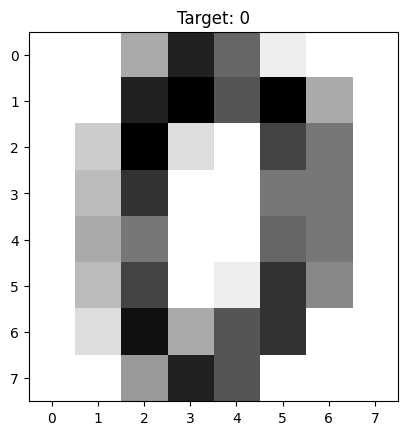

Shape of data: (1797, 64)
Shape of target: (1797,)


In [129]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
digits = load_digits()

X = digits.data
y = digits.target

plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation="nearest")
plt.title(f"Target: {digits.target[0]}")
plt.show()

print(f"Shape of data: {X.shape}")
print(f"Shape of target: {y.shape}")

## Splitting the dataset

In [130]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
val_percentage = 0.15 / (1-0.15)
X_train , X_val , y_train , y_val = train_test_split(X_temp, y_temp, test_size=val_percentage, stratify=y_temp, random_state=42)

## Standarizing the data

In [131]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = np.array(scaler.fit_transform(X_train))
X_val_scaled = np.array(scaler.transform(X_val))
X_test_scaled = np.array(scaler.transform(X_test))
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

## main()

Validation accuracy for lambda =   1e-09   is   0.9481481481481482
Validation accuracy for lambda =   0.0001   is   0.9481481481481482
Validation accuracy for lambda =   0.001   is   0.9481481481481482
Validation accuracy for lambda =   0.01   is   0.9518518518518518
Validation accuracy for lambda =   0.1   is   0.9444444444444444
Best lambda is : 0.01


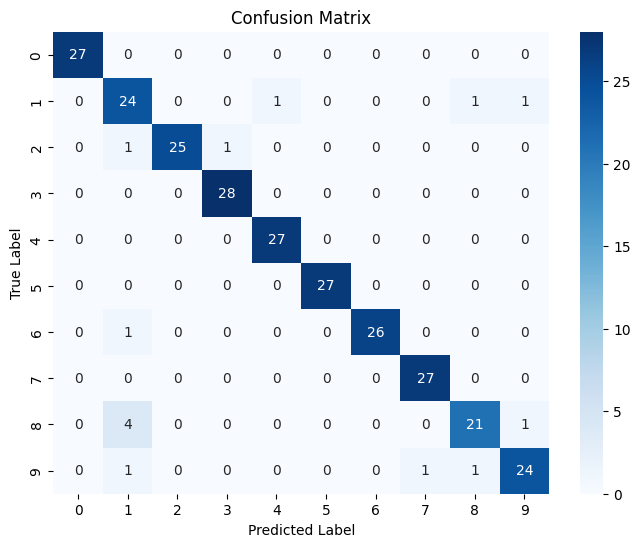

In [132]:
lambdas = [1e-9, 1e-4, 1e-3, 1e-2, 1e-1 ]
best_lambda = calc_best_lambda(X_train_scaled, y_train, X_val_scaled, y_val, lambdas)
pi_k, mu_k, cov_mat_reg = train_best_lambda(X_train_scaled , X_val_scaled, y_train, y_val , best_lambda)
test_model(X_test_scaled, y_test, pi_k, mu_k, cov_mat_reg)